# Generate Spectra from Orca Output

import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
import re
from itertools import islice

### Function to read a table of the user-defined spectral type from Orca

Reads an Orca output line by line to extract data of the user-defined spectral type  

Args: 
> filename (str): path+name of Orca output.  
> pattern (str): The string pattern of user-defined spectral type to search for.  
> num_transitions (int): #transitions or nstates to be included in the plot.  

Returns:  
> found_lines: A list of the lines found after the pattern 
    (a table of the states and their respective vertical transition energies + oscillator strength)

In [2]:
def read_lines_after_pattern(filename, pattern, num_transitions):
    found_lines = []
    headline=4
    num_lines=num_transitions+headline
    
    with open(filename, 'r') as f:
        for line in f:
            if re.search(pattern, line):
# Pattern found, now read from headline to num_lines (This will skip reading the table header.)
                for next_line in islice(f,headline, num_lines):
                    found_lines.append(next_line.strip())
                break  # Stop after reading the desired lines

    return found_lines

### Function to separate the table of the spectrum into column

In [3]:
def extract_osc(extracted_content,num_transitions):
    oscillator_strengths=[]
    for lines in extracted_content:
        columns=lines.split( )
        data_row={
          'transition': str(columns[0]+columns[1]+columns[2]),
          'energy_eV': float(columns[3]),
          'energy_cm':float(columns[4]),
          'wavelength':float(columns[5]),
          'osc_strength':float(columns[6])
        }
        oscillator_strengths.append(data_row)

    return oscillator_strengths

### Spectral convolution using Gaussian function

$$
    I=A\exp \left[-4\log{2} \left( \frac {\lambda-\lambda_0}{\sigma} \right)^2 \right]
$$
> I = intensity  
A = Oscillator strength  
$\lambda$ = an arbitrary energy/wavelength  
$\lambda_0$ = the energy/wavelength at the band maximum  
$\sigma$ = full width at half maximum (FWHM) # adust for broader/narrower peaks

To convolute the spectral bands, one would need to calculate the intensity at each transition ($\lambda_0$[i] and A[i]) from $\lambda$=min_wl to max_wl (increment=resolution value) to get one Gaussian band. If the two transitions are close to each other or the FWHM is large, the Gaussian bands can coalesce. 

In [4]:
def gaussian_spectra(oscillator_strengths, fwhm,resolution,xmin,xmax):
    df = pd.DataFrame(oscillator_strengths)
    df = df.sort_values('wavelength')
    energy=[]
    osc=[]
    
    min_wl = max(xmin, df['wavelength'].min() - 50)
    max_wl = min(xmax, df['wavelength'].max() + 50)
    
    # Create wavelength range for the spectrum
    lambda1 = np.arange(min_wl, max_wl, resolution)
    spectrum = np.zeros_like(lambda1, dtype=float)
    prefactor=-(4*np.log(2))
              
    # Generate the spectrum using Gaussian functions
    for _, row in df.iterrows():
        lambda0 = row['wavelength']
        intensity = row['osc_strength']
        val=(lambda1-lambda0)/fwhm
        spectrum += intensity * np.exp(prefactor*val**2)
        energy.append(row['wavelength'])
        osc.append(row['osc_strength'])
    
    
    return lambda1,spectrum,energy,osc

### Plot spectrum

 The function `plot_spectrum` directly calls `plt.show()` inside it, which is typically used to display the plot immediately in an interactive environment. When saving a figure, you usually want to create the figure and axes, plot on them, and then save the figure object *before* showing it (or without showing it if you only intend to save).  

Plot the simulated UV-Vis spectrum.
    
Args:
> `wavelengths (array)`: Array of wavelengths.  
`spectrum (array)`: Array of spectrum intensities.  
`energy (array)`: Array of transition energies.  
`osc (array)`: Array of oscillator strengths.  
`fwhm (float)`: Full width at half maximum for the Gaussian broadening.  
`resolution (float)`: Resolution of the generated spectrum.  
`num_transition (int)`: Number of transitions used.  
`xmin (float)`: Minimum wavelength for the plot.  
`xmax (float)`: Maximum wavelength for the plot.  

Returns:
> `matplotlib.figure.Figure`: The created figure object.

In [5]:
def plot_spectrum(wavelengths, spectrum, energy, osc, fwhm, resolution, num_transition, xmin, xmax):
    max_osc=np.max(osc) # the strongest Oscillator strength
    lambda_max = energy[np.argmax(osc)] # lambda_max at max_osc

    # create figure and axis from the plot function
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot the simulated spectrum
    ax.plot(wavelengths, spectrum, 'b-', linewidth=2, label='Simulated UV-Vis Spectrum')
    
    # Add stick spectrum (transitions)
    for Enm,osc_strength in zip(energy,osc):
        ax.plot((Enm,Enm),(0,osc_strength),c="r")
    
    
    # Find peaks in the simulated spectrum
    peaks, _ = find_peaks(spectrum, height=np.max(spectrum)*0.1)
    peak_wavelengths = wavelengths[peaks]
    peak_intensities = spectrum[peaks]

    # Add peak labels
    for wl, intensity in zip(peak_wavelengths, peak_intensities):
        if intensity > np.max(spectrum) * 0.2:  # Only label significant peaks
            ax.text(wl+fwhm, intensity*1.0, f"{wl:.1f}", ha='center', fontsize=10)
    
    # Add styling and information
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Intensity (arb. units)', fontsize=12)
    ax.set_title('Simulated UV-Vis Absorption Spectrum', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(xmin, xmax)


    # Add information about the calculation
    info_text = (
        f"FWHM: {fwhm} nm\n"
        f"Resolution: {resolution} nm\n"
        f"#Transitions: {num_transition}\n"
        f"Strongest: {lambda_max:.1f} nm (f={max_osc:.4f})"
    )
    ax.annotate(info_text, xy=(0.02, 0.98), xycoords='axes fraction',
                va='top', ha='left', fontsize=10,
                bbox=dict(boxstyle='round', fc='white', alpha=0.8))
    
    fig.tight_layout()
    return fig

## Main Program

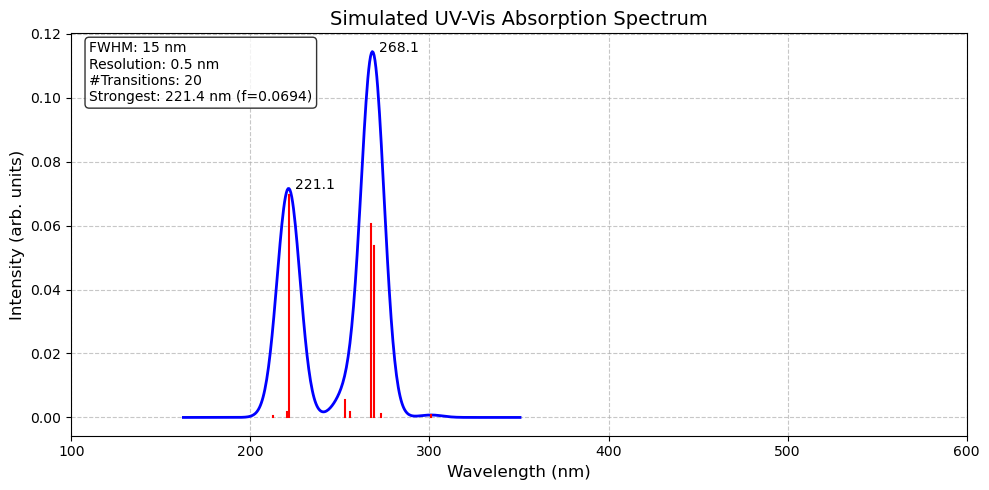

In [6]:
# spectral variables (unit= nm)
xmin=100
xmax=600
resolution=0.5 # nm
fwhm=15 # Full width at half maximum (nm) - adjust for broader/narrower peaks

# define file path and name for the code to generate spectrum
path="/Users/tosapornsattasathuchana/Desktop"
file="test.log"
file_path = path + '/' + file
# search_pattern for UV/Vis spectrum
search_pattern = r"ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS"

num_transitions = 20  # Number of lines to extract after the pattern

# Step 1: read a table of the user-defined spectral type from Orca
extracted_content = read_lines_after_pattern(file_path, search_pattern, num_transitions)

### print list in extracted_content
#for line in extracted_content:
#    print(line)

# Step 2: separate the table of the spectrum into column
oscillator_strengths=extract_osc(extracted_content,num_transitions)

# Step 3: Spectral convolution using Gaussian function
x,y,energy,osc=gaussian_spectra(oscillator_strengths,fwhm,resolution,xmin,xmax)

# Now, create the figure using the modified function
fig1 = plot_spectrum(x, y, energy, osc, fwhm, resolution, num_transitions, xmin, xmax)

# Save the figure to a file (e.g., 'png', 'pdf', 'svg', 'jpg')
# bbox_inches='tight' helps prevent labels or titles from being cut off
figname=file_path[:-4] + '.png'  # Remove the ".log" extension
fig1.savefig(figname, bbox_inches='tight', transparent=True,dpi=300)

# If you still want to display the plot in the notebook after saving:
#plt.show()

## Practice

#### 1. save figure into jpg format with name of 'newplot1.jpg'

In [ ]:
# To remove the ".log" extension, file_path[:-4]
figname=
fig1.savefig(figname, bbox_inches='tight', transparent=True,dpi=300)

#### 2. replot from x=200 to 350

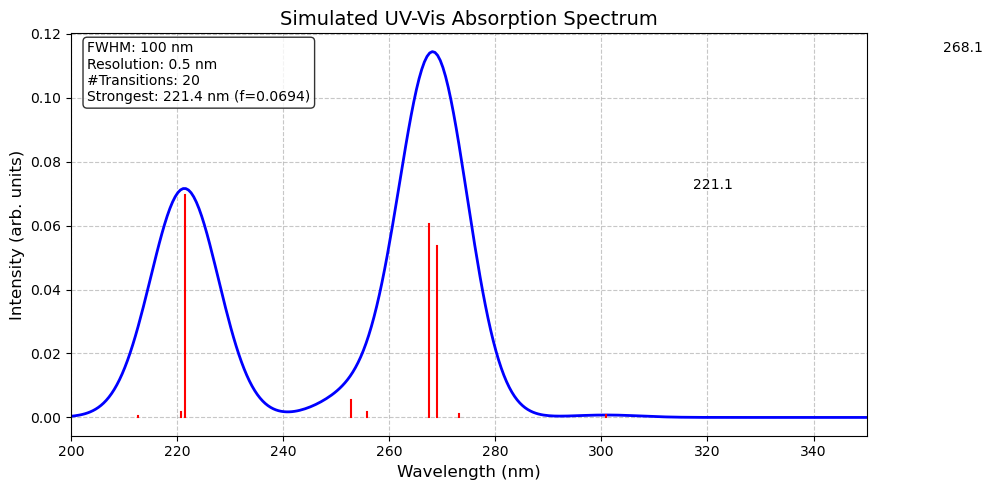

In [13]:
xmin=200
xmax=350
# Now, create the figure using the modified function
fig1 = plot_spectrum(x, y, energy, osc, fwhm, resolution, num_transitions, xmin, xmax)

#### 3.

In [ ]:
# spectral variables
xmin=100
xmax=600
resolution=0.5 
fwhm=15 
num_transitions = 20
# define file path and name for the code to generate spectrum
path="/Users/tosapornsattasathuchana/Desktop"
file="test.log"
file_path = path + file
search_pattern = r"ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS"

extracted_content = read_lines_after_pattern(file_path, search_pattern, num_transitions)
oscillator_strengths=extract_osc(extracted_content,num_transitions)
x,y,energy,osc=gaussian_spectra(oscillator_strengths,fwhm,resolution,xmin,xmax)

fig1 = plot_spectrum(x, y, energy, osc, fwhm, resolution, num_transitions, xmin, xmax)
figname=file_path[:-4] + '.png'  # Remove the ".log" extension
fig1.savefig(figname, bbox_inches='tight', transparent=True,dpi=300)


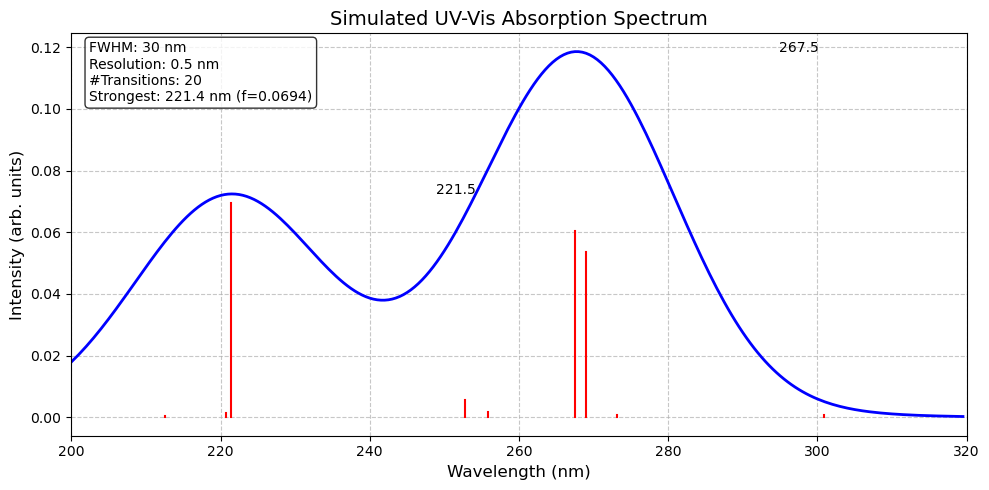

In [25]:
# spectral variables
xmin=200
xmax=320
resolution=0.5 
fwhm=30 
num_transitions = 20
# define file path and name for the code to generate spectrum
x,y,energy,osc=gaussian_spectra(oscillator_strengths,fwhm,resolution,xmin,xmax)

fig1 = plot_spectrum(x, y, energy, osc, fwhm, resolution, num_transitions, xmin, xmax)
